In [1]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# hacks
import os
import sys
nb_dir = os.path.split(os.path.abspath(os.getcwd()))[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

### Test Files:

In [4]:
import PDFfield

### Regeneration:

In [34]:
### uncomment the following cells to force regeneration (takes about 20 minutes / file)
### there's no need to do it unless higher resolution is needed..
helium  = 4
oxygen  = 16
iron    = 56
uranium = 238

In [30]:
# If you want to fetch a rendered model
# Happens nearly instantly.
PDFdict = PDFfield.precompute(iron, 20e18)

In [ ]:
PDFdict = PDFfield.precompute(helium, 2e18, autoload=False)
PDFdict = PDFfield.precompute(helium, 20e18, autoload=False)
PDFdict = PDFfield.precompute(helium, 200e18, autoload=False)

  progress: 44.3%   elapsed: 435.31 [sec]                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [27]:
#PDFdict = PDFfield.precompute(oxygen, 2e18, autoload=False)
#PDFdict = PDFfield.precompute(oxygen, 20e18, autoload=False)
#PDFdict = PDFfield.precompute(oxygen, 200e18, autoload=False)

In [28]:
#PDFdict = PDFfield.precompute(iron, 2e18, autoload=False)
#PDFdict = PDFfield.precompute(iron, 20e18, autoload=False)
#PDFdict = PDFfield.precompute(iron, 200e18, autoload=False)

In [29]:
#PDFdict = PDFfield.precompute(uranium, 2e18, autoload=False)
#PDFdict = PDFfield.precompute(uranium, 20e18, autoload=False)
#PDFdict = PDFfield.precompute(uranium, 200e18, autoload=False)

In [31]:
PDFdict.keys()

['y', 'x', 'z', 'PDF']

In [32]:
PDFdict['x'].shape

(120L,)

In [33]:
PDFdict['PDF'].shape

(120L, 120L, 120L)

# Sun Plots

z = 0.1 [AU]
B_rho (-),  B_theta (+),  B_z (+)


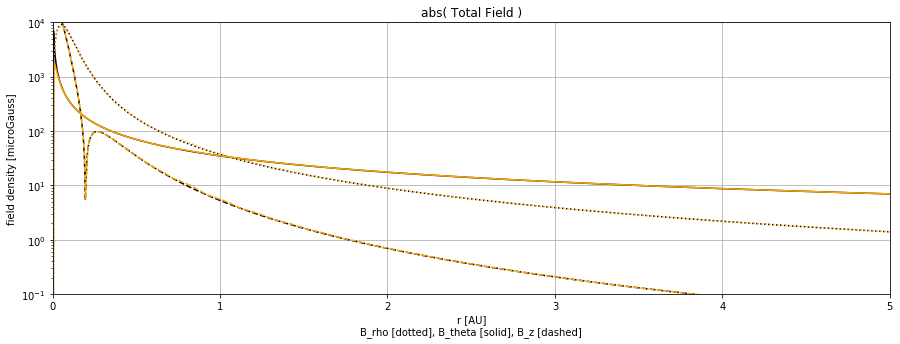

In [9]:
import Transform
import SolarMagneticModel

def plotPolar(z=.1):
    """Plot total solar magnetic field model by polar coordinates.
    Uses EMR approximation for the ring component.
    Black lines come from SolarMagneticModel
    Orange lines come from interpolation from a precomputation.
    """
    print 'z = {} [AU]'.format(z)
    r_list = np.linspace(0, 5, 1000) # [AU]
    # q for quick (Bfield), s for slow (SolarMagneticModel)
    qB_rho   = []
    qB_theta = []
    qB_z     = []
    sB_rho   = []
    sB_theta = []
    sB_z     = []    
    for r in r_list:
        cartesian_pos = np.array([ r, 0, z ] ) # [AU]
        Gauss2Tesla = 1e4 # [Gauss / Tesla]
        cartesian_qB = Bfield.cartesianTesla(cartesian_pos) * Gauss2Tesla # [Gauss]
        cartesian_sB = SolarMagneticModel.sumBfieldGauss(cartesian_pos)   # [Gauss]        
        polar_qB = Transform.cartesian2polar( cartesian_pos, cartesian_qB )['vec']
        polar_sB = Transform.cartesian2polar( cartesian_pos, cartesian_sB )['vec']        
        qB_rho.append(  polar_qB[0])
        qB_theta.append(polar_qB[1])
        qB_z.append(    polar_qB[2])
        sB_rho.append(  polar_sB[0])
        sB_theta.append(polar_sB[1])
        sB_z.append(    polar_sB[2])
    
    if qB_rho[-1] >= 0:
        print 'B_rho (+), ',
    else:
        print 'B_rho (-), ',

    if qB_theta[-1] >= 0:
        print 'B_theta (+), ',
    else:
        print 'B_theta (-), ',

    if qB_z[-1] >= 0:
        print 'B_z (+)'
    else:
        print 'B_z (-)'
    
    qB_rho   = np.abs( qB_rho   ) * 1e6 # [microGauss]
    qB_theta = np.abs( qB_theta ) * 1e6 # [microGauss]
    qB_z     = np.abs( qB_z     ) * 1e6 # [microGauss]
    sB_rho   = np.abs( sB_rho   ) * 1e6 # [microGauss]
    sB_theta = np.abs( sB_theta ) * 1e6 # [microGauss]
    sB_z     = np.abs( sB_z     ) * 1e6 # [microGauss]
    
    plt.figure(figsize=(15,5))
    plt.yscale('log')
    plt.xlim(0,5)
    plt.ylim(.1,1e4)
    plt.grid(True)
    plt.xlabel('r [AU]\n' + 'B_rho [dotted], B_theta [solid], B_z [dashed]')
    plt.ylabel('field density [microGauss]')
    plt.title('abs( Total Field )')
    
    plt.plot( r_list, sB_rho, color='black', linestyle='dotted' )
    plt.plot( r_list, sB_theta, color='black', linestyle='solid' )
    plt.plot( r_list, sB_z, color='black', linestyle='dashed' )

    plt.plot( r_list, qB_rho, color='orange', linestyle='dotted' )
    plt.plot( r_list, qB_theta, color='orange', linestyle='solid' )
    plt.plot( r_list, qB_z, color='orange', linestyle='dashed' )

plotPolar()

# Performance race

In [5]:
import random
import time
import Bfield
import SolarMagneticModel

def interpolate(positions):
    with open('interpolate.field','w') as f:
        start = time.time()
        for position in positions:
            position = np.array(position)
            B = Bfield.cartesianTesla(position)
    return time.time() - start

def compute(positions):
    with open('compute.field','w') as f:
        start = time.time()
        for position in positions:
            position = np.array(position)
            B = SolarMagneticModel.sumBfieldTesla(position)
    return time.time() - start


In [7]:
spacelimit = 6
samples = 10000
np.random.seed(12345)
x = np.random.uniform(-spacelimit, spacelimit, samples)
y = np.random.uniform(-spacelimit, spacelimit, samples)
z = np.random.uniform(-spacelimit, spacelimit, samples)

positions = np.array(zip(x, y, z))
int_time = interpolate(positions)
comp_time = compute(positions)

print 'computational time for {} samples: {} [seconds]'.format(samples,comp_time)
print 'interpolation time for {} samples: {} [seconds]'.format(samples,int_time)
print 'performance ratio (comp/interp): {:.3}x'.format(comp_time/float(int_time))

computational time for 10000 samples: 106.963000059 [seconds]
interpolation time for 10000 samples: 7.28099989891 [seconds]
performance ratio (comp/interp): 14.7x


# Z vs Y Field near sun

In [96]:
# Z-Y meridian plane (x = 0)
Ro = 0.00465 # radius of Sun in [AU]
w = 50.* Ro
Z, Y = np.mgrid[-w:w:500j,-w:w:500j]
z = Z.flatten()
y = Y.flatten()
size = z.size
x = np.zeros(size)

bx = np.zeros(size)
bz = np.zeros(size)
by = np.zeros(size)
for i, (ix, iy, iz) in enumerate(zip(x, y, z)):
    position = np.array([ix, iy, iz])
    bx[i], by[i], bz[i] = Bfield.cartesianTesla(position)

BX = bx.reshape(Z.shape)
BY = by.reshape(Z.shape)
BZ = bz.reshape(Z.shape)

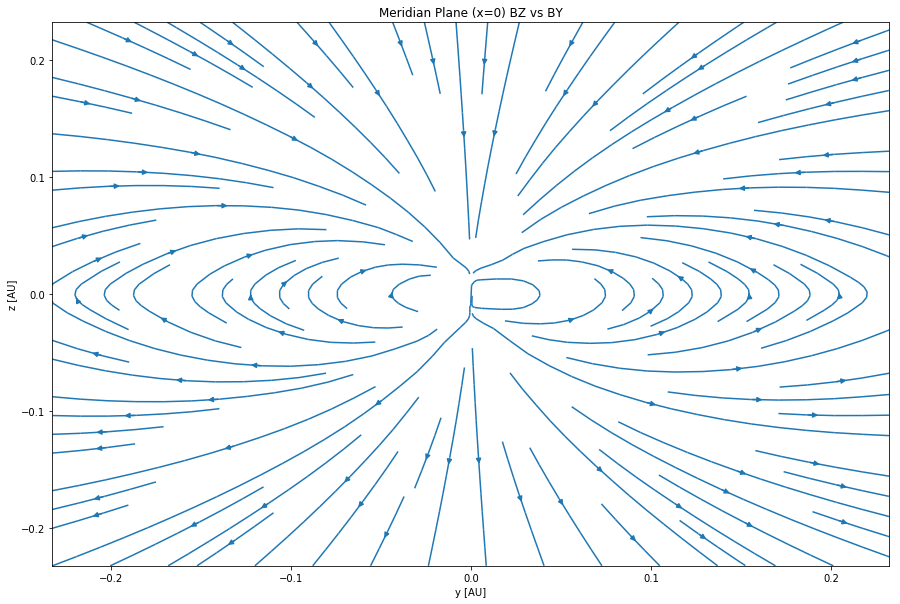

In [97]:
# plot it
plt.figure(figsize=(15,10))
plt.xlim(-w,w) # actually y-axis
plt.ylim(-w,w) # actually z-axis
plt.xlabel('y [AU]')
plt.ylabel('z [AU]')
plt.title('Meridian Plane (x=0) BZ vs BY')
plt.streamplot(Y,Z,BY,BZ)

# Y vs X near sun

In [100]:
# Y-X equitorial plane (z = 0)
Ro = 0.00465 # radius of Sun in [AU]
w = 50.* Ro
Y, X = np.mgrid[-w:w:500j,-w:w:500j]
y = Y.flatten()
x = X.flatten()
size = z.size
z = np.zeros(size)

bx = np.zeros(size)
bz = np.zeros(size)
by = np.zeros(size)
for i, (ix, iy, iz) in enumerate(zip(x, y, z)):
    position = np.array([ix, iy, iz])
    bx[i], by[i], bz[i] = Bfield.cartesianTesla(position)

BX = bx.reshape(Y.shape)
BY = by.reshape(Y.shape)
BZ = bz.reshape(Y.shape)

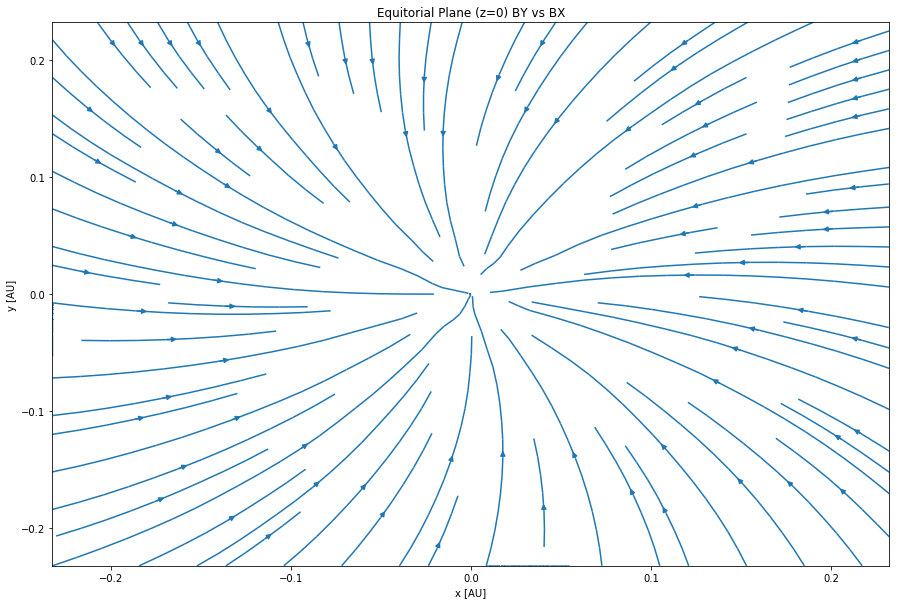

In [102]:
# plot it
plt.figure(figsize=(15,10))
plt.xlim(-w,w) # actually x-axis
plt.ylim(-w,w) # actually y-axis
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.title('Equitorial Plane (z=0) BY vs BX')
plt.streamplot(X,Y,BX,BY)

# Equitorial Plane

In [115]:
# Y-X equitorial plane (z = 0)
w = 6.
Y, X = np.mgrid[-w:w:500j,-w:w:500j]
y = Y.flatten()
x = X.flatten()
size = z.size
z = np.zeros(size)

bx = np.zeros(size)
bz = np.zeros(size)
by = np.zeros(size)
for i, (ix, iy, iz) in enumerate(zip(x, y, z)):
    position = np.array([ix, iy, iz])
    bx[i], by[i], bz[i] = Bfield.cartesianTesla(position)

BX = bx.reshape(Y.shape)
BY = by.reshape(Y.shape)
BZ = bz.reshape(Y.shape)

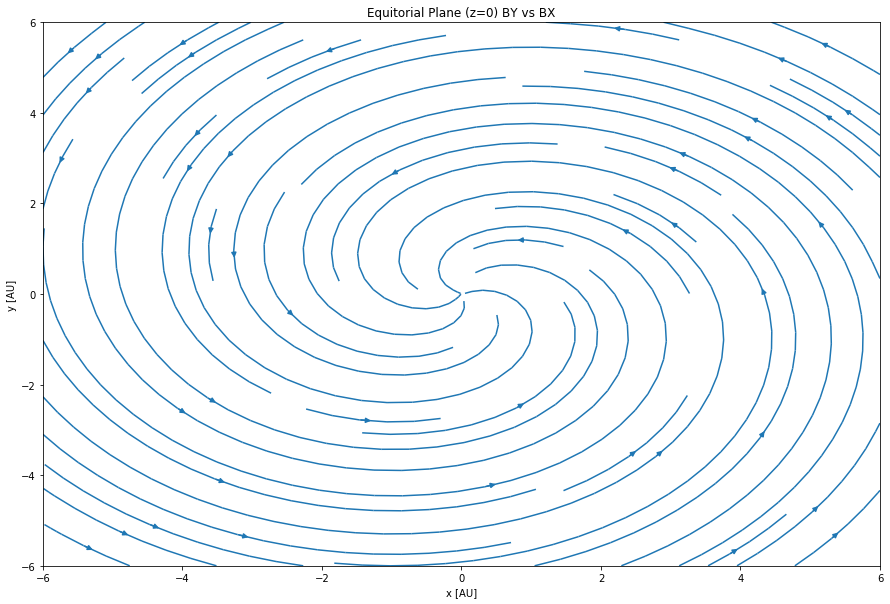

In [116]:
# plot it
plt.figure(figsize=(15,10))
plt.xlim(-w,w) # actually x-axis
plt.ylim(-w,w) # actually y-axis
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.title('Equitorial Plane (z=0) BY vs BX')
plt.streamplot(X,Y,BX,BY)

# Quiver

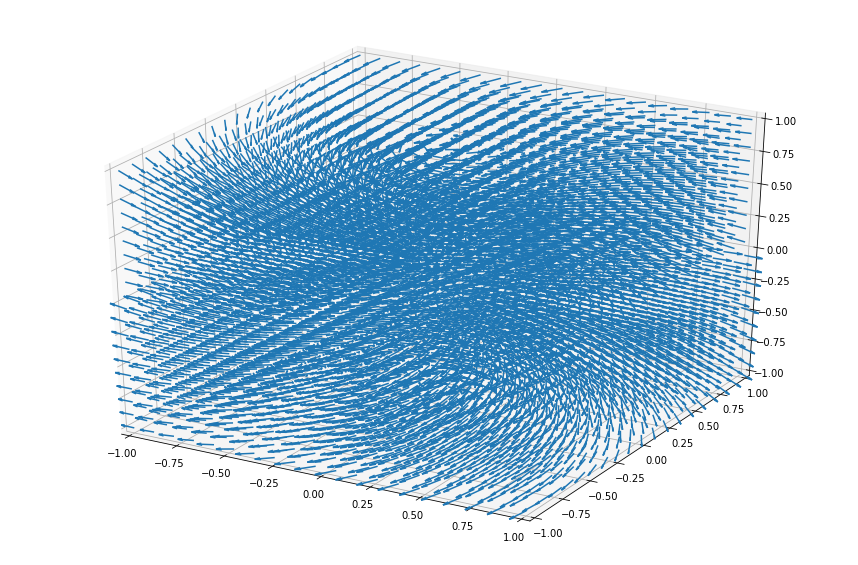

In [116]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

# radius of Sun [astronomical units]
Ro = 0.00465
limit = 1

ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_zlim(-limit, limit)

#rho = np.logspace( np.log10(Ro), np.log10(limit), 100)
#theta = np.linspace( 0, 2*np.pi, 10 )
#z = np.logspace( np.log10(Ro), np.log10(limit), 50 )
#z = np.sort( np.append(-z, z) )

#R, T, Z = np.meshgrid( rho, theta, z, indexing='ij' )
#X = R * np.cos(T)
#Y = R * np.sin(T)
#Z = Z
x = np.linspace(-limit, limit, 20)
y = np.linspace(-limit, limit, 20)
z = np.linspace(-limit, limit, 20)
X, Y, Z = np.meshgrid(x,y,z)
shape = X.shape

x = X.flatten()
y = Y.flatten()
z = Z.flatten()
size = x.size

bx = np.zeros(size)
by = np.zeros(size)
bz = np.zeros(size)

for i, (ix, iy, iz) in enumerate( zip(x,y,z) ):
    bx[i], by[i], bz[i] = Bfield.cartesianTesla(np.array([ix,iy,iz]))

Bx = bx.reshape(shape)
By = by.reshape(shape)
Bz = bz.reshape(shape)

ax.quiver(X, Y, Z, Bx, By, Bz, length=.1, normalize=True)

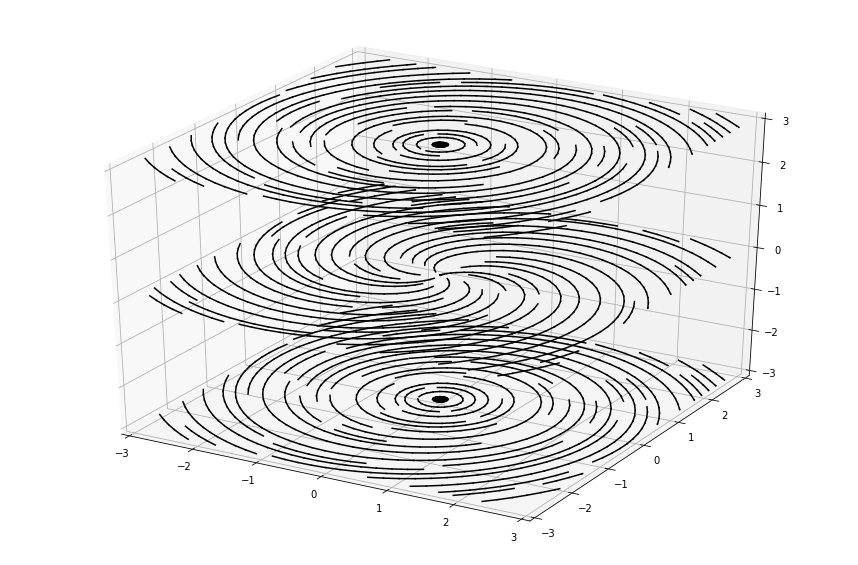

In [120]:
fig_tmp, ax_tmp = plt.subplots()

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_zlim(-limit, limit)

# radius of Sun [astronomical units]
Ro = 0.00465
limit = 3
samples = 30

linrange = np.linspace( -limit, limit, samples )
X, Y = np.meshgrid( linrange, linrange, indexing='ij' )
shape = X.shape

x = X.flatten()
y = Y.flatten()
size = x.size

Zrange = np.array([-3, 0, 3])
for zval in Zrange:

    z  = np.ones(size) * zval
    bx = np.zeros(size)
    by = np.zeros(size)
    bz = np.zeros(size)
    bmag = np.zeros(size)

    for i, (ix, iy, iz) in enumerate(zip(x,y,z)):
        bx[i], by[i], bz[i] = Bfield.cartesianTesla(np.array([ix,iy,iz]))
    
    Bx = bx.reshape(shape)
    By = by.reshape(shape)
    
    stream = ax_tmp.streamplot(X.T, Y.T, Bx.T, By.T)
    plt.close(fig_tmp)
    lines = stream.lines.get_paths()

    for line in lines:
        xx = line.vertices.T[0]
        yy = line.vertices.T[1]
        zz = np.ones(xx.size) * zval
        ax.plot(xx, yy, zz, color='k')

plt.show()

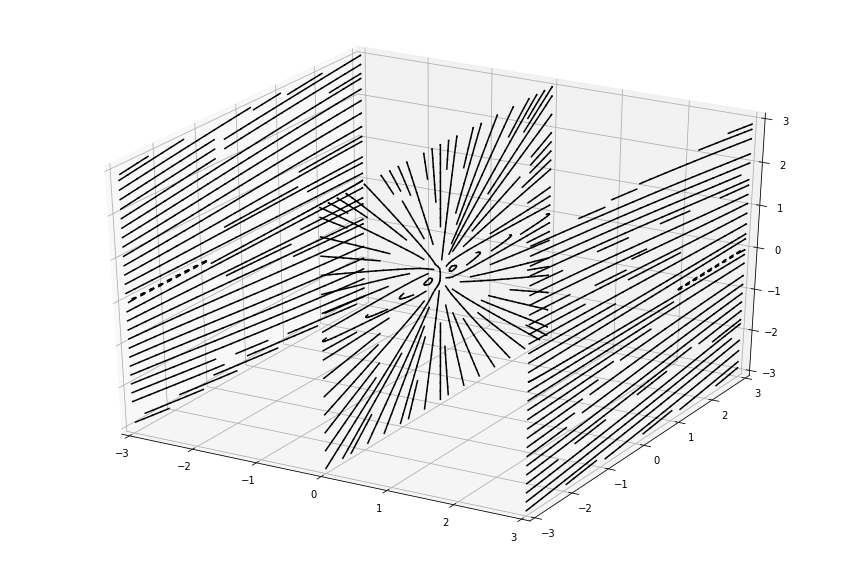

In [105]:
fig_tmp, ax_tmp = plt.subplots()

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_zlim(-limit, limit)

# radius of Sun [astronomical units]
Ro = 0.00465
limit = 3
samples = 30

linrange = np.linspace( -limit, limit, samples )
Y, Z = np.meshgrid( linrange, linrange, indexing='ij' )
shape = Y.shape

y = Y.flatten()
z = Z.flatten()
size = y.size

Xrange = np.array([-3, 0, 3])
for xval in Xrange:

    x  = np.ones(size) * xval
    bx = np.zeros(size)
    by = np.zeros(size)
    bz = np.zeros(size)

    for i, (ix, iy, iz) in enumerate(zip(x,y,z)):
        bx[i], by[i], bz[i] = Bfield.cartesianTesla(np.array([ix,iy,iz]))

    By = by.reshape(shape)
    Bz = bz.reshape(shape)

    stream = ax_tmp.streamplot(Y.T, Z.T, By.T, Bz.T)
    plt.close(fig_tmp)
    lines = stream.lines.get_paths()

    for line in lines:
        yy = line.vertices.T[0]
        zz = line.vertices.T[1]
        xx = np.ones(xx.size) * xval
        ax.plot(xx, yy, zz, color='k')

plt.show()

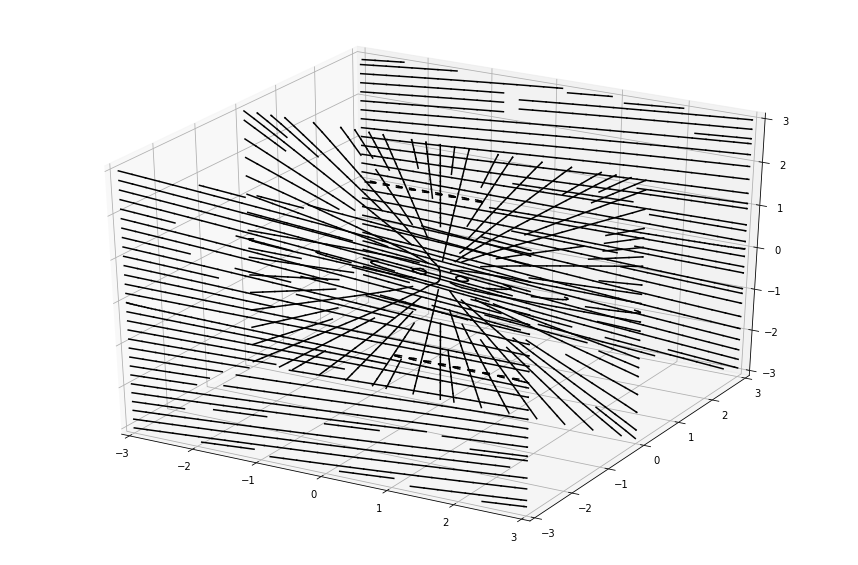

In [106]:
fig_tmp, ax_tmp = plt.subplots()

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_zlim(-limit, limit)

# radius of Sun [astronomical units]
Ro = 0.00465
limit = 3
samples = 30

linrange = np.linspace( -limit, limit, samples )
X, Z = np.meshgrid( linrange, linrange, indexing='ij' )
shape = X.shape

x = X.flatten()
z = Z.flatten()
size = x.size

Yrange = np.array([-3, 0, 3])
for yval in Yrange:

    y  = np.ones(size) * yval
    bx = np.zeros(size)
    by = np.zeros(size)
    bz = np.zeros(size)

    for i, (ix, iy, iz) in enumerate(zip(x,y,z)):
        bx[i], by[i], bz[i] = Bfield.cartesianTesla(np.array([ix,iy,iz]))

    Bx = bx.reshape(shape)
    Bz = bz.reshape(shape)

    stream = ax_tmp.streamplot(X.T, Z.T, Bx.T, Bz.T)
    plt.close(fig_tmp)
    lines = stream.lines.get_paths()

    for line in lines:
        xx = line.vertices.T[0]
        zz = line.vertices.T[1]
        yy = np.ones(xx.size) * yval
        ax.plot(xx, yy, zz, color='k')

plt.show()

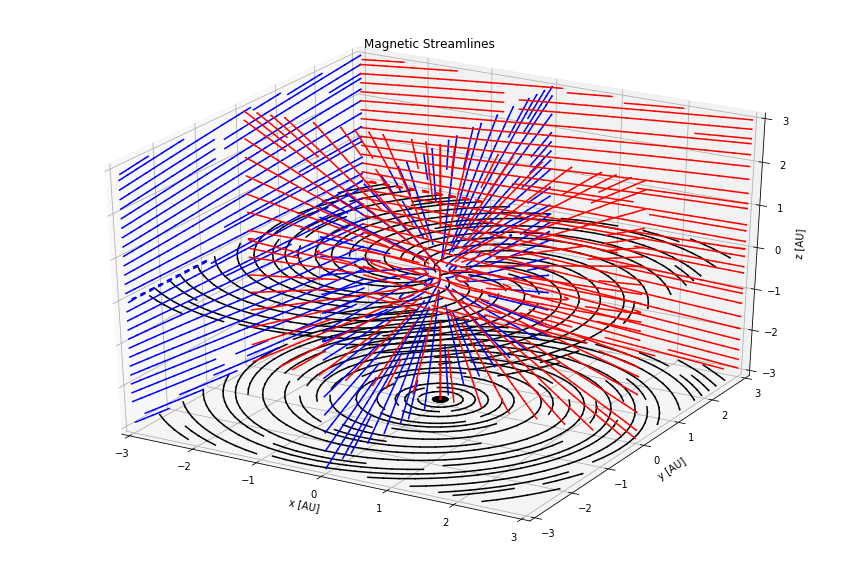

In [126]:
fig_tmp, ax_tmp = plt.subplots()

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_zlim(-limit, limit)
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.set_title('Magnetic Streamlines')

# radius of Sun [astronomical units]
Ro = 0.00465
limit = 3
samples = 30

linrange = np.linspace( -limit, limit, samples )


# X vs Y, Z = 0
#---------------
X, Y = np.meshgrid( linrange, linrange, indexing='ij' )
shape = X.shape

x = X.flatten()
y = Y.flatten()
size = x.size

Zrange = np.array([-3, 0])
for zval in Zrange:

    z  = np.ones(size) * zval
    bx = np.zeros(size)
    by = np.zeros(size)
    bz = np.zeros(size)

    for i, (ix, iy, iz) in enumerate(zip(x,y,z)):
        bx[i], by[i], bz[i] = Bfield.cartesianTesla(np.array([ix,iy,iz]))

    Bx = bx.reshape(shape)
    By = by.reshape(shape)

    stream = ax_tmp.streamplot(X.T, Y.T, Bx.T, By.T)
    plt.close(fig_tmp)
    lines = stream.lines.get_paths()

    for line in lines:
        xx = line.vertices.T[0]
        yy = line.vertices.T[1]
        zz = np.ones(xx.size) * zval
        ax.plot(xx, yy, zz, color='k')

# Y vs Z, X = 0
#---------------
Y, Z = np.meshgrid( linrange, linrange, indexing='ij' )

y = Y.flatten()
z = Z.flatten()

Xrange = np.array([-3, 0])
for xval in Xrange:

    x  = np.ones(size) * xval
    bx = np.zeros(size)
    by = np.zeros(size)
    bz = np.zeros(size)

    for i, (ix, iy, iz) in enumerate(zip(x,y,z)):
        bx[i], by[i], bz[i] = Bfield.cartesianTesla(np.array([ix,iy,iz]))

    By = by.reshape(shape)
    Bz = bz.reshape(shape)

    stream = ax_tmp.streamplot(Y.T, Z.T, By.T, Bz.T)
    plt.close(fig_tmp)
    lines = stream.lines.get_paths()

    for line in lines:
        yy = line.vertices.T[0]
        zz = line.vertices.T[1]
        xx = np.ones(xx.size) * xval
        ax.plot(xx, yy, zz, color='b')

# X vs Z, Y = 0
#---------------
X, Z = np.meshgrid( linrange, linrange, indexing='ij' )

x = X.flatten()
z = Z.flatten()

Yrange = np.array([0, 3])
for yval in Yrange:

    y  = np.ones(size) * yval
    bx = np.zeros(size)
    by = np.zeros(size)
    bz = np.zeros(size)

    for i, (ix, iy, iz) in enumerate(zip(x,y,z)):
        bx[i], by[i], bz[i] = Bfield.cartesianTesla(np.array([ix,iy,iz]))

    Bx = bx.reshape(shape)
    Bz = bz.reshape(shape)

    stream = ax_tmp.streamplot(X.T, Z.T, Bx.T, Bz.T)
    plt.close(fig_tmp)
    lines = stream.lines.get_paths()

    for line in lines:
        xx = line.vertices.T[0]
        zz = line.vertices.T[1]
        yy = np.ones(xx.size) * yval
        ax.plot(xx, yy, zz, color='r')

plt.show()